<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/notebooks/T7_torch_NN_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pipeline for deep learning with PyTorch**

## Major steps from data to deployment

| Step                | Key Actions                                                                | Main PyTorch Classes/Methods                  |
|---------------------|----------------------------------------------------------------------------|-----------------------------------------------|
| Data Preparation    | Load, transform, batch, and split data                                     | `torch.utils.data.Dataset`, `DataLoader`, `torchvision.transforms`  |
| Model Development   | Define architecture, choose loss/optimizer, set hyperparameters            | `torch.nn.Module`, `torch.nn.Parameter`, `torch.nn.functional`, `torch.optim` |
| Model Training      | Forward pass, loss computation, backward pass, parameter update, epochs    | `forward()`, `loss.backward()`, `optimizer.step()`, `optimizer.zero_grad()` , `model.train()` |
| Validation          | Evaluate on validation set, compute metrics, tune hyperparameters          | `model.eval()`, `torch.no_grad()`, metric functions (e.g., `torchmetrics`) |
| Testing/Deployment  | Final evaluation on test set, save and deploy model                        | `torch.save()`, `torch.load()`, `model.eval()`, `torch.jit` |

## Typical training loop.

Recall that the whole set of examples is visited during one epoch. Moreover, the *dataloader* groups examples in batches, and defines some other functionalities like shuffling the examples each time the iterator is created with `for inputs, targets in dataloader` in the example below.

For standard neural network training in PyTorch, inputs and targets should be tensors. This can be dealt with in the *data preparation* step, using `transforms` when creating the custom `Dataset` class for the problem at hand (see https://github.com/isa-ulisboa/greends-pml/blob/main/notebooks/T6_pytorch_dataset_dataloader.ipynb).

As discussed in https://github.com/isa-ulisboa/greends-pml/blob/main/docs/T1_basic_concepts.md for a simple linear regression problem, PyTorch uses backpropagation as the strategy to updates the model weights for loss minimization. The exact same idea can be generalized to multilayer neural networks and deep-learning.

The typical training loop in PyTorch is the following. To apply

```
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
```


## Example for data preparation and model training: the MNIST data set

### Step 1: Data preparation

In [2]:
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [3]:
# Define a transformation to flatten the 8x8 images
transform = transforms.Compose([
    transforms.Resize((8, 8)),         # Resize the PIL Image to 8x8 first (MNIST images are originally 28x28)
    transforms.ToTensor(),             # Then convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # Finally, flatten the tensor
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


Dataloaders `train_loader` and `test_loader` are iterators which allow to access examples and labels.
- what type of objects are returned by those dataloaders; what is their shape?
- Why dataloaders for train and test differ with respect to the option `shuffle`?

### Step 2: model development

In [4]:
# Model Development: the model is a multilayer perceptron with one hidden layer
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Since we are using 8x8 MNIST and flatenning the input, the input size is 8 * 8 = 64
input_size = 8 * 8
hidden_size = 128
num_classes = 10 # 0-9 digits

model = SimpleNN(input_size, hidden_size, num_classes)

Questions:
- The model architecture depends on the input data shape. The input images of MNIST are originally of size $28 \times 28$ but they have been resized to $8 \times 8$ pixels. Which changes do you need to do in the script to use size $16 \times 16$? And if you just want to use the original $28 \times 28$ size?
- The hidden layer has 128 neurons. Where do you change that parameter in the code?
- What is a `ReLU` unit and why this type of unit is necessary for deep learning?

## Step 3: Model training

In [6]:
# Loss and optimizer: necessary for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# number of epochs
num_epochs = 3

#### Typical training loop

In [19]:
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


epoch: 1; time: 1747327099.4489129
epoch: 2; time: 1747327113.3021023
epoch: 3; time: 1747327125.1360195


#### Change device: run training on GPU

Training involves many large matrix computations. In general, this is done faster if it is parellelized over multiple cores. One can determine which device, either `cuda` (for GPU) or `cpu`, is used for training. Both model and data must be moved to the right device.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device) #<<<<<<<<<< move model to device

#move data to GPU
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    for images, labels in train_loader:
        images = images.to(device)  #<<<<<<<<<< move data to device
        labels = labels.to(device)  #<<<<<<<<<< move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Using device: cuda
epoch: 1; time: 1747327362
epoch: 2; time: 1747327371
epoch: 3; time: 1747327380


Which of the following parameters that were defined earlier about the data, model or training you expect will drive computation time reduction when using GPU?
- image size;
- number of nodes in the hidden layer;
- loss function;
- optimizer;
- number of epochs.



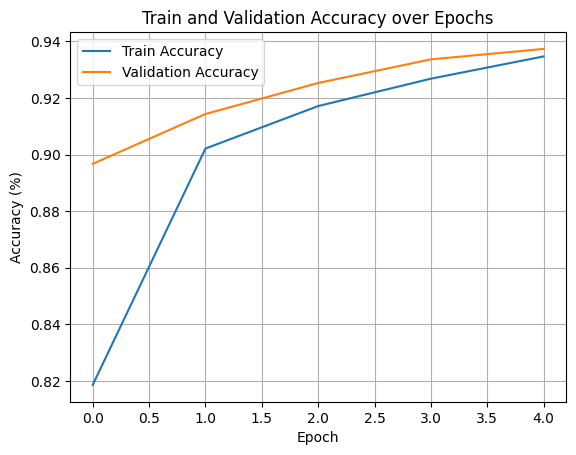

In [4]:





# Model Training
num_epochs = 5

# Computes the accuracy for a batch: outputs are probability-like values
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = len(labels)
    return correct / total

# History object to keep track of accuracy along epochs
history = {'epoch': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    model.train()
    batch_accuracies=[]
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # compute accuracy over the batch
        batch_accuracies.append(compute_accuracy(outputs, labels))
    history['epoch'].append(epoch)
    history['train_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))

    # Validation phase
    model.eval()
    batch_accuracies=[]
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            # compute accuracy over the batch
            batch_accuracies.append(compute_accuracy(outputs, labels))
        history['val_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))

# accuracy plot
plt.plot(history['epoch'], history['train_accuracy'], label='Train Accuracy')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()



Try the following changes in the code:
- The input images of MNIST are originally of size $28 \times 28$ but they have been resized to $8 \times 8$ pixels. Which changes do you need to do in the script to use size $16 \times 16$? And if you just want to use the original $28 \times 28$ size?
- The hidden layer has 128 neurons. Where do you change that parameter in the code?
- Add to the code the following functionality: output a plot that shows the evolution of the loss along epochs
- From the visualization of that plot, do you think that 5 epochs are enough, or should the model train longer than that?
-
- What is the *shape* of `images` returned by `for images, labels in train_loader`: add a print to your code to verify your answer.
- How would add an extra layer `softmax` so the outputs of your model are probabilities?

